In [76]:
import tensorflow as tf
import numpy as np

def generate_carlini_l2(image, model, epsilon, max_iter, learning_rate):
    """
    Generates a Carlini & Wagner L2 adversarial example for a given image and model.

    Args:
        image: The input image to be attacked.
        model: The target model.
        epsilon: The maximum L2 norm of the perturbation.
        max_iter: The maximum number of iterations for the attack.

    Returns:
        The adversarial example image.
    """

    # Ensure the image has the correct shape
    image = tf.convert_to_tensor(image)
    image = tf.reshape(image, (1, *image.shape))

    # Initialize perturbed_image before the loop
    perturbed_image = tf.cast(image, dtype=tf.float32)

    # Define the objective function for the attack
    def objective_function(perturbed_image):
        prediction = model(perturbed_image)
        target_class = tf.argmax(prediction[0])
        f_x = prediction[0][target_class]
        return -f_x

    # Define the L2 norm penalty
    def l2_norm(perturbed_image):
        perturbed_image = tf.cast(perturbed_image, dtype=tf.float32)
        image_cast = tf.cast(image, dtype=tf.float32)
        return tf.reduce_sum(tf.square(perturbed_image - image_cast))

    # Define the gradient of the objective function
    @tf.custom_gradient
    def gradient_objective_function(perturbed_image):
        with tf.GradientTape() as tape:
            tape.watch(perturbed_image)
            loss = objective_function(perturbed_image)
        gradient = tape.gradient(loss, perturbed_image)
        def grad(d_loss):
            return d_loss * gradient
        return loss, grad
    
    prediction = model(image)
    target_class = tf.argmax(prediction[0])

    for i in range(max_iter):
        # Step 1: Compute the gradient of the objective function
        with tf.GradientTape() as tape:
            tape.watch(perturbed_image)
            loss = objective_function(perturbed_image) + epsilon * l2_norm(perturbed_image)
        gradient, = tape.gradient(loss, perturbed_image)

        # Step 2: Project the gradient onto the L2 sphere
        gradient = tf.nn.l2_normalize(gradient, axis=1)

        # Step 3: Update the perturbed image
        perturbed_image = perturbed_image + learning_rate * gradient

        # Step 4: Clip pixel values and ensure image validity
        perturbed_image = tf.clip_by_value(perturbed_image, 0, 1)

        # Step 5: Check if the image is now misclassified
        prediction = model(perturbed_image)
        if tf.argmax(prediction[0]) != target_class:
            break

    # Return the adversarial example
    return perturbed_image.numpy()[0]

1/1 [==============================] - 0s 135ms/step


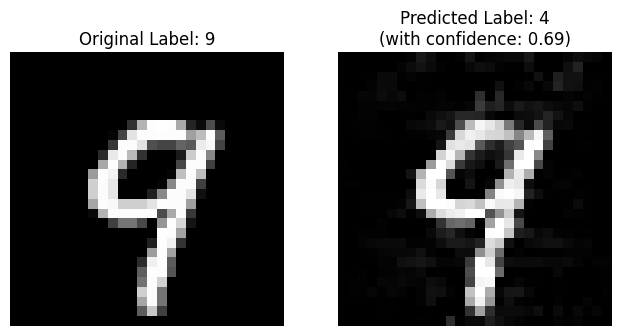

In [77]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load the FCN model you created earlier
fcn_model = tf.keras.models.load_model("../Models/Mnist/mnist_model_2LFCN.karas")

# Load the MNIST dataset
mnist = tf.keras.datasets.mnist
(_, _), (test_images, test_labels) = mnist.load_data()
test_images = test_images / 255.0  # Preprocess the data

# Select a random image from the test dataset
random_index = 12  # np.random.randint(0, len(test_images))
input_image = test_images[random_index]
original_label = test_labels[random_index]

# Define an epsilon value for the C&W untargeted attack
epsilon = 0.001
max_iter=50
learning_rate = 0.04

# Use the generate_cw_untargeted function to generate a perturbed image
perturbed_image = generate_carlini_l2(input_image, fcn_model, epsilon, max_iter, learning_rate)

# Calculate the difference between the original and perturbed images
difference_image = input_image - perturbed_image

# Perform inference on the perturbed image
perturbed_image_reshaped = perturbed_image.reshape(1, 28, 28)  # Reshape to match the model's input shape
predictions = fcn_model.predict(perturbed_image_reshaped)

# Get the predicted class label
predicted_label = np.argmax(predictions)
confidence = np.max(predictions)

# Display the original image, perturbed image, and the difference
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(input_image, cmap='gray')
plt.title(f'Original Label: {original_label}')
plt.axis('off')

plt.subplot(132)
plt.imshow(perturbed_image_reshaped[0], cmap='gray')
plt.title(f'Predicted Label: {predicted_label}\n(with confidence: {confidence:.2f})')
plt.axis('off')

plt.show()

1/1 [==============================] - 0s 21ms/step


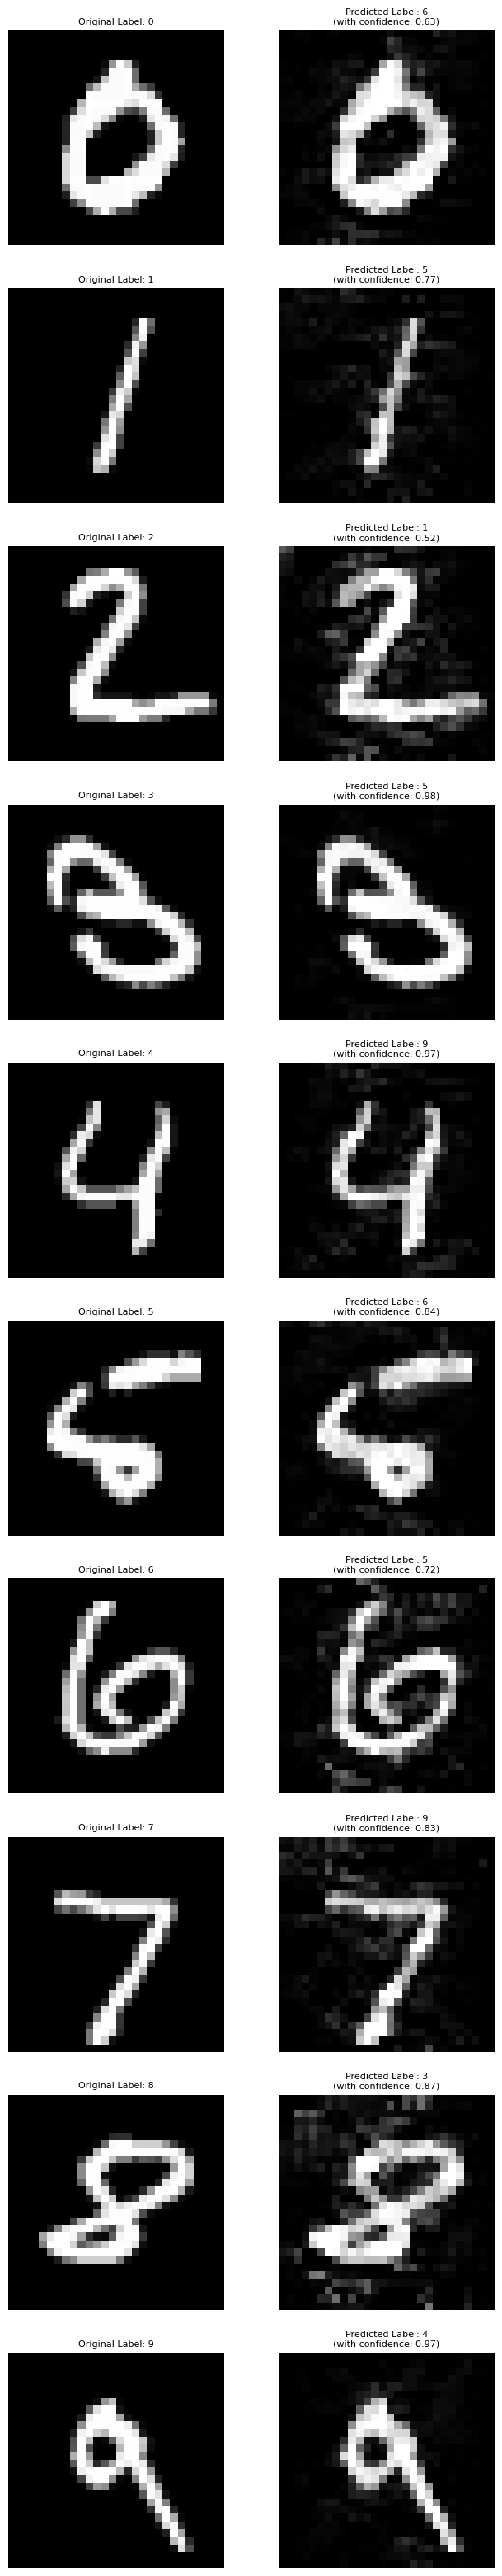

In [80]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load the FCN model you created earlier
fcn_model = tf.keras.models.load_model("../Models/Mnist/mnist_model_2LFCN.karas")

# Load the MNIST dataset
mnist = tf.keras.datasets.mnist
(_, _), (test_images, test_labels) = mnist.load_data()
test_images = test_images / 255.0  # Preprocess the data

# Select one sample from each class in the test dataset
indices = []
for i in range(10):  # Assuming there are 10 classes
    indices.append(np.where(test_labels == i)[0][0])

# Define an epsilon value for the FGSM attack
epsilon = 0.25

plt.figure(figsize=(12, 40))

for i, index in enumerate(indices):
    input_image = test_images[index]
    original_label = test_labels[index]

    # Define an epsilon value for the C&W untargeted attack
    epsilon = 0.005
    max_iter=50
    learning_rate = 0.1

    # Use the generate_cw_untargeted function to generate a perturbed image
    perturbed_image = generate_carlini_l2(input_image, fcn_model, epsilon, max_iter, learning_rate)

    # Calculate the difference between the original and perturbed images
    difference_image = input_image - perturbed_image

    # Perform inference on the perturbed image
    perturbed_image_reshaped = perturbed_image.reshape(1, 28, 28)  # Reshape to match the model's input shape
    predictions = fcn_model.predict(perturbed_image_reshaped)

    # Get the predicted class label
    predicted_label = np.argmax(predictions)
    confidence = np.max(predictions)

    # Display the original image, perturbed image, and the difference
    plt.subplot(10, 3, i*3+1)
    plt.imshow(input_image, cmap='gray')
    plt.title(f'Original Label: {original_label}',fontsize=8)
    plt.axis('off')

    plt.subplot(10, 3, i*3+2)
    plt.imshow(perturbed_image_reshaped[0], cmap='gray')
    plt.title(f'Predicted Label: {predicted_label}\n(with confidence: {confidence:.2f})',fontsize=8)
    plt.axis('off')

plt.show()

In [81]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load the FCN model
fcn_model = tf.keras.models.load_model("../Models/Mnist/mnist_model_2LFCN.karas")

# Load the MNIST dataset
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images / 255.0  # Preprocess the training data
test_images = test_images / 255.0  # Preprocess the test data

# Define an epsilon value for the C&W untargeted attack
epsilon = 0.005
max_iter=50
learning_rate = 0.1

# Specify the number of perturbed training and testing images
num_perturbed_train_images = 20000
num_perturbed_test_images = 5000

# Create a new dataset with perturbed training images
perturbed_train_images = []

print("Generating perturbed training images:")
for i, image in enumerate(train_images[:num_perturbed_train_images]):
    perturbed_image = generate_carlini_l2(image, fcn_model, epsilon, max_iter, learning_rate)
    perturbed_train_images.append(perturbed_image)
    
    # Print progress
    if (i + 1) % 100 == 0 or (i + 1) == num_perturbed_train_images:
        print(f"Processed {i + 1}/{num_perturbed_train_images} images")

perturbed_train_images = np.array(perturbed_train_images)

# Optionally, you can save the perturbed training images and labels to a new dataset
np.savez_compressed('perturbed_mnist_2LFCN_CW_train.npz', images=perturbed_train_images, labels=train_labels[:num_perturbed_train_images])

# Create a new dataset with perturbed test images
perturbed_test_images = []

print("\nGenerating perturbed test images:")
for i, image in enumerate(test_images[:num_perturbed_test_images]):
    perturbed_image = generate_carlini_l2(image, fcn_model, epsilon, max_iter, learning_rate)
    perturbed_test_images.append(perturbed_image)
    
    # Print progress
    if (i + 1) % 100 == 0 or (i + 1) == num_perturbed_test_images:
        print(f"Processed {i + 1}/{num_perturbed_test_images} images")

perturbed_test_images = np.array(perturbed_test_images)

# Optionally, you can save the perturbed test images and labels to a new dataset
np.savez_compressed('perturbed_mnist_2LFCN_CW_test.npz', images=perturbed_test_images, labels=test_labels[:num_perturbed_test_images])

Generating perturbed training images:
Processed 100/20000 images
Processed 200/20000 images
Processed 300/20000 images
Processed 400/20000 images
Processed 500/20000 images
Processed 600/20000 images
Processed 700/20000 images
Processed 800/20000 images
Processed 900/20000 images
Processed 1000/20000 images
Processed 1100/20000 images
Processed 1200/20000 images
Processed 1300/20000 images
Processed 1400/20000 images
Processed 1500/20000 images
Processed 1600/20000 images
Processed 1700/20000 images
Processed 1800/20000 images
Processed 1900/20000 images
Processed 2000/20000 images
Processed 2100/20000 images
Processed 2200/20000 images
Processed 2300/20000 images
Processed 2400/20000 images
Processed 2500/20000 images
Processed 2600/20000 images
Processed 2700/20000 images
Processed 2800/20000 images
Processed 2900/20000 images
Processed 3000/20000 images
Processed 3100/20000 images
Processed 3200/20000 images
Processed 3300/20000 images
Processed 3400/20000 images
Processed 3500/2000

In [82]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load the FCN model
fcn_model = tf.keras.models.load_model("../Models/Mnist/mnist_model_LENET.karas")

# Load the MNIST dataset
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images / 255.0  # Preprocess the training data
test_images = test_images / 255.0  # Preprocess the test data

# Define an epsilon value for the C&W untargeted attack
epsilon = 0.005
max_iter=50
learning_rate = 0.1

# Specify the number of perturbed training and testing images
num_perturbed_train_images = 20000
num_perturbed_test_images = 5000

# Create a new dataset with perturbed training images
perturbed_train_images = []

print("Generating perturbed training images:")
for i, image in enumerate(train_images[:num_perturbed_train_images]):
    perturbed_image = generate_carlini_l2(image, fcn_model, epsilon, max_iter, learning_rate)
    perturbed_train_images.append(perturbed_image)
    
    # Print progress
    if (i + 1) % 100 == 0 or (i + 1) == num_perturbed_train_images:
        print(f"Processed {i + 1}/{num_perturbed_train_images} images")

perturbed_train_images = np.array(perturbed_train_images)

# Optionally, you can save the perturbed training images and labels to a new dataset
np.savez_compressed('perturbed_mnist_LENET_CW_train.npz', images=perturbed_train_images, labels=train_labels[:num_perturbed_train_images])

# Create a new dataset with perturbed test images
perturbed_test_images = []

print("\nGenerating perturbed test images:")
for i, image in enumerate(test_images[:num_perturbed_test_images]):
    perturbed_image = generate_carlini_l2(image, fcn_model, epsilon, max_iter, learning_rate)
    perturbed_test_images.append(perturbed_image)
    
    # Print progress
    if (i + 1) % 100 == 0 or (i + 1) == num_perturbed_test_images:
        print(f"Processed {i + 1}/{num_perturbed_test_images} images")

perturbed_test_images = np.array(perturbed_test_images)

# Optionally, you can save the perturbed test images and labels to a new dataset
np.savez_compressed('perturbed_mnist_LENET_CW_test.npz', images=perturbed_test_images, labels=test_labels[:num_perturbed_test_images])

Generating perturbed training images:
Processed 100/20000 images
Processed 200/20000 images
Processed 300/20000 images
Processed 400/20000 images
Processed 500/20000 images
Processed 600/20000 images
Processed 700/20000 images
Processed 800/20000 images
Processed 900/20000 images
Processed 1000/20000 images
Processed 1100/20000 images
Processed 1200/20000 images
Processed 1300/20000 images
Processed 1400/20000 images
Processed 1500/20000 images
Processed 1600/20000 images
Processed 1700/20000 images
Processed 1800/20000 images
Processed 1900/20000 images
Processed 2000/20000 images
Processed 2100/20000 images
Processed 2200/20000 images
Processed 2300/20000 images
Processed 2400/20000 images
Processed 2500/20000 images
Processed 2600/20000 images
Processed 2700/20000 images
Processed 2800/20000 images
Processed 2900/20000 images
Processed 3000/20000 images
Processed 3100/20000 images
Processed 3200/20000 images
Processed 3300/20000 images
Processed 3400/20000 images
Processed 3500/2000

157/157 [==============================] - 1s 8ms/step
Accuracy on perturbed dataset: 1.44%


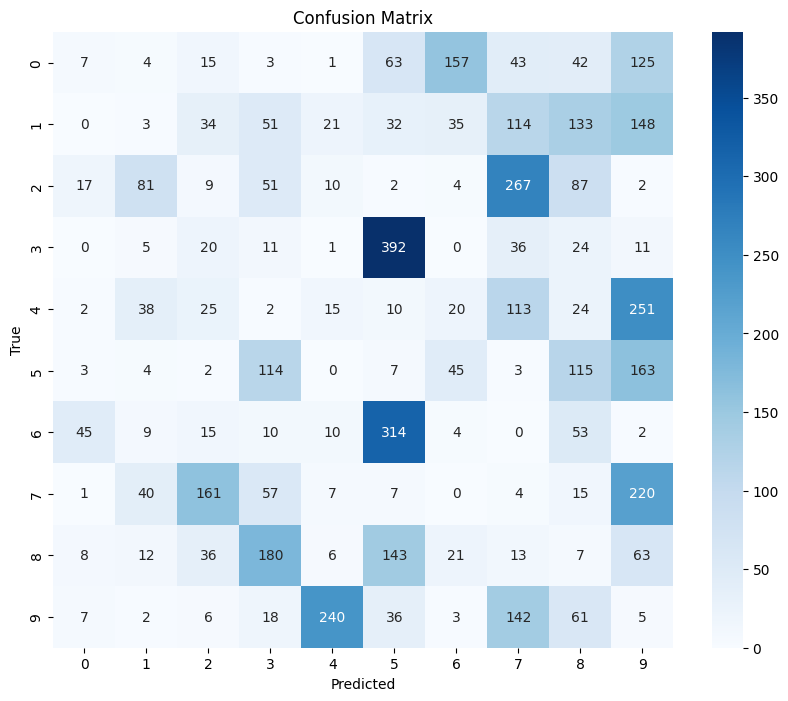

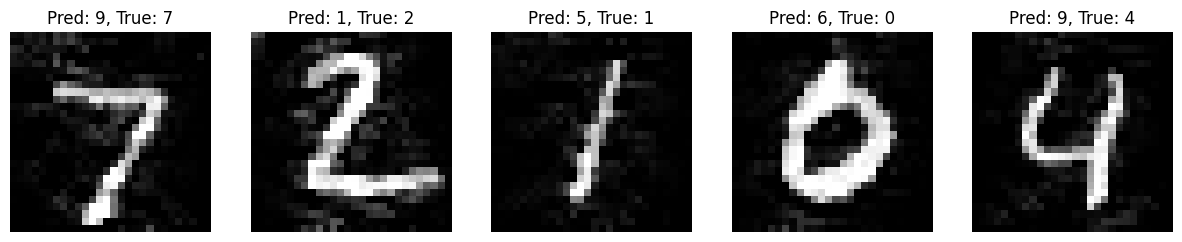

In [90]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load the perturbed dataset
perturbed_data = np.load('perturbed_mnist_2LFCN_CW_test.npz')
perturbed_images = perturbed_data['images']
perturbed_labels = perturbed_data['labels']

# Load the FCN model
fcn_model = tf.keras.models.load_model("../Models/Mnist/mnist_model_2LFCN.karas")

# Perform inference on the perturbed images
predictions = fcn_model.predict(perturbed_images)

# Get the predicted labels
predicted_labels = np.argmax(predictions, axis=1)

# Evaluate the accuracy
accuracy = np.mean(np.equal(predicted_labels, perturbed_labels))
print(f'Accuracy on perturbed dataset: {accuracy * 100:.2f}%')

# Calculate the confusion matrix
conf_matrix = confusion_matrix(perturbed_labels, predicted_labels)
class_names = [str(i) for i in range(10)]  # Assuming you have 10 classes (adjust if needed)

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Display some examples
num_examples = 5
plt.figure(figsize=(15, 4))
for i in range(num_examples):
    plt.subplot(1, num_examples, i + 1)
    plt.imshow(perturbed_images[i].reshape(28, 28), cmap='gray')
    plt.title(f'Pred: {predicted_labels[i]}, True: {perturbed_labels[i]}')
    plt.axis('off')

plt.show()

157/157 [==============================] - 1s 6ms/step
Accuracy on perturbed dataset: 96.20%


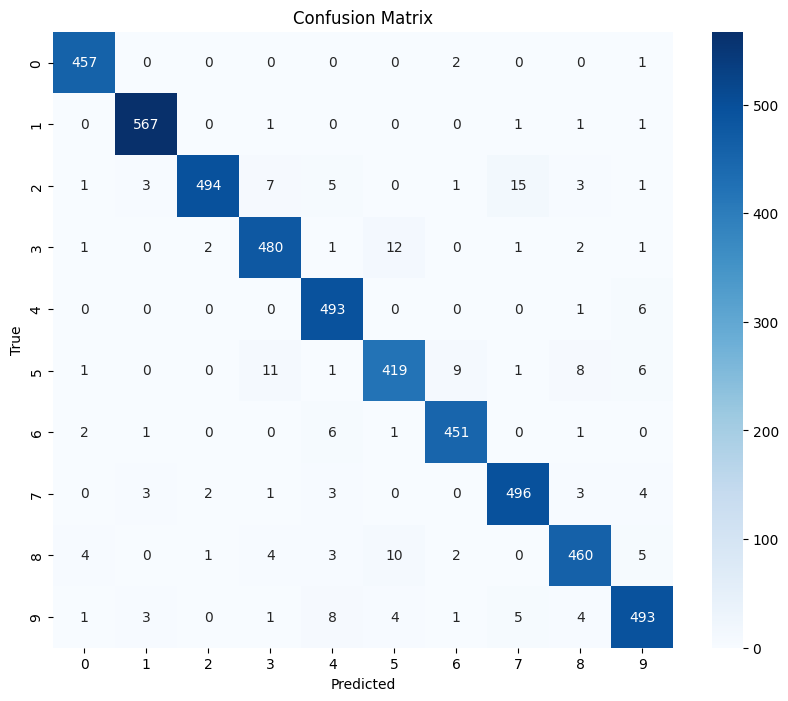

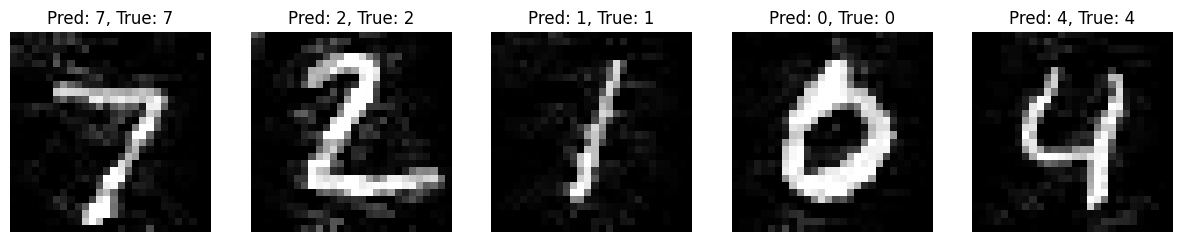

In [91]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load the perturbed dataset
perturbed_data = np.load('perturbed_mnist_2LFCN_CW_test.npz')
perturbed_images = perturbed_data['images']
perturbed_labels = perturbed_data['labels']

# Load the FCN model
fcn_model = tf.keras.models.load_model("../Models/Mnist/mnist_model_LENET.karas")

# Perform inference on the perturbed images
predictions = fcn_model.predict(perturbed_images)

# Get the predicted labels
predicted_labels = np.argmax(predictions, axis=1)

# Evaluate the accuracy
accuracy = np.mean(np.equal(predicted_labels, perturbed_labels))
print(f'Accuracy on perturbed dataset: {accuracy * 100:.2f}%')

# Calculate the confusion matrix
conf_matrix = confusion_matrix(perturbed_labels, predicted_labels)
class_names = [str(i) for i in range(10)]  # Assuming you have 10 classes (adjust if needed)

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Display some examples
num_examples = 5
plt.figure(figsize=(15, 4))
for i in range(num_examples):
    plt.subplot(1, num_examples, i + 1)
    plt.imshow(perturbed_images[i].reshape(28, 28), cmap='gray')
    plt.title(f'Pred: {predicted_labels[i]}, True: {perturbed_labels[i]}')
    plt.axis('off')

plt.show()

157/157 [==============================] - 1s 6ms/step
Accuracy on perturbed dataset: 94.42%


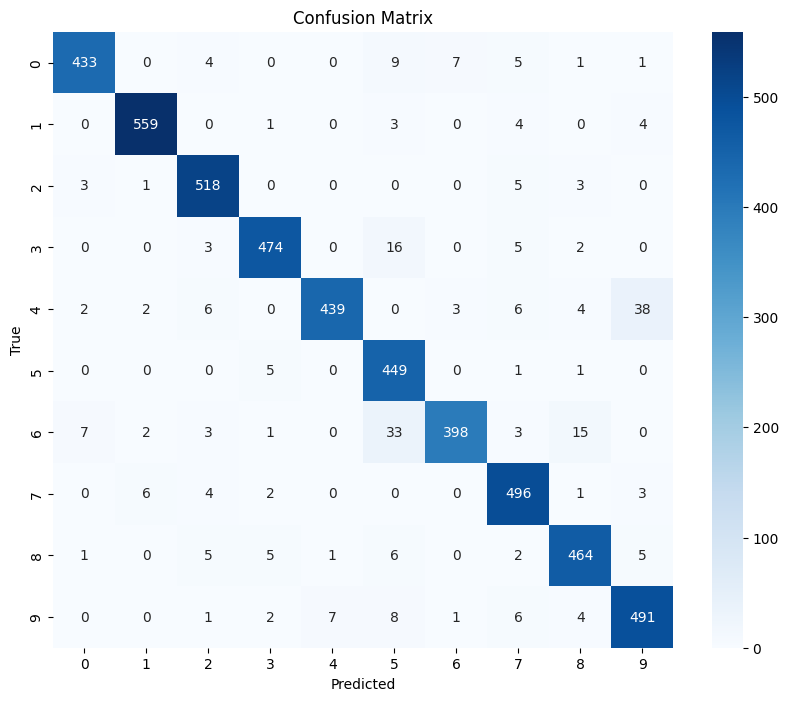

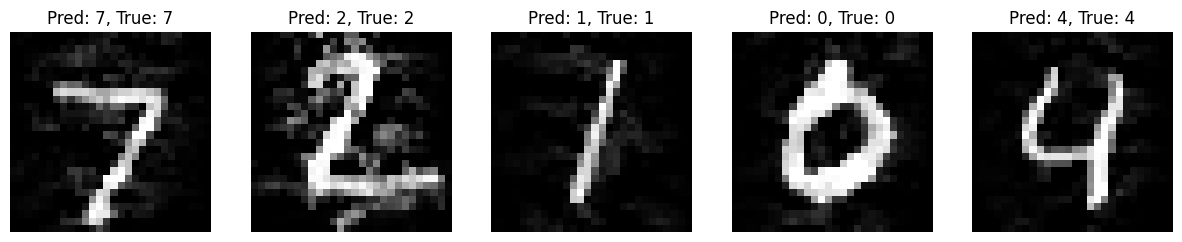

In [89]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load the perturbed dataset
perturbed_data = np.load('perturbed_mnist_LENET_CW_test.npz')
perturbed_images = perturbed_data['images']
perturbed_labels = perturbed_data['labels']

# Load the FCN model
fcn_model = tf.keras.models.load_model("../Models/Mnist/mnist_model_2LFCN.karas")

# Perform inference on the perturbed images
predictions = fcn_model.predict(perturbed_images)

# Get the predicted labels
predicted_labels = np.argmax(predictions, axis=1)

# Evaluate the accuracy
accuracy = np.mean(np.equal(predicted_labels, perturbed_labels))
print(f'Accuracy on perturbed dataset: {accuracy * 100:.2f}%')

# Calculate the confusion matrix
conf_matrix = confusion_matrix(perturbed_labels, predicted_labels)
class_names = [str(i) for i in range(10)]  # Assuming you have 10 classes (adjust if needed)

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Display some examples
num_examples = 5
plt.figure(figsize=(15, 4))
for i in range(num_examples):
    plt.subplot(1, num_examples, i + 1)
    plt.imshow(perturbed_images[i].reshape(28, 28), cmap='gray')
    plt.title(f'Pred: {predicted_labels[i]}, True: {perturbed_labels[i]}')
    plt.axis('off')

plt.show()

157/157 [==============================] - 1s 6ms/step
Accuracy on perturbed dataset: 1.22%


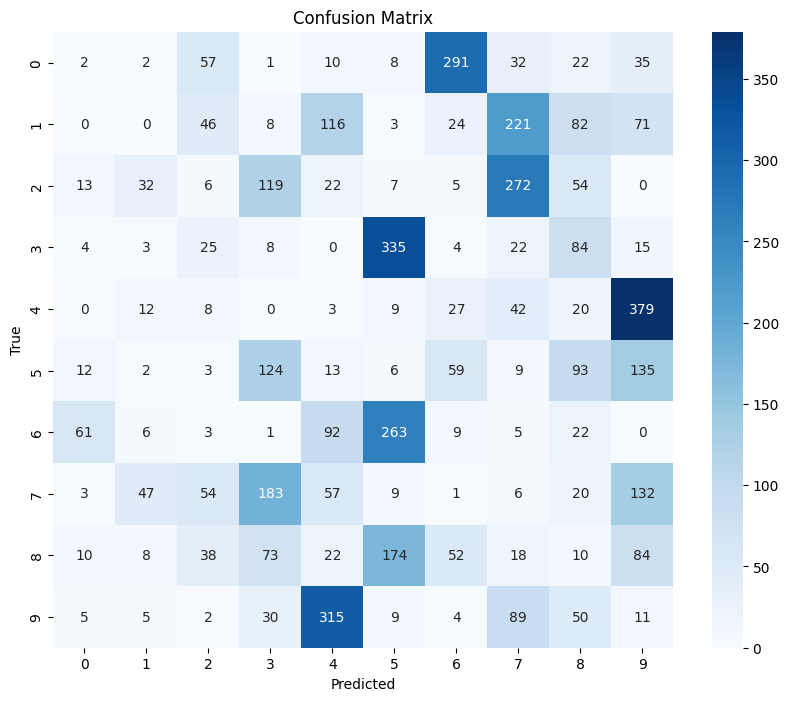

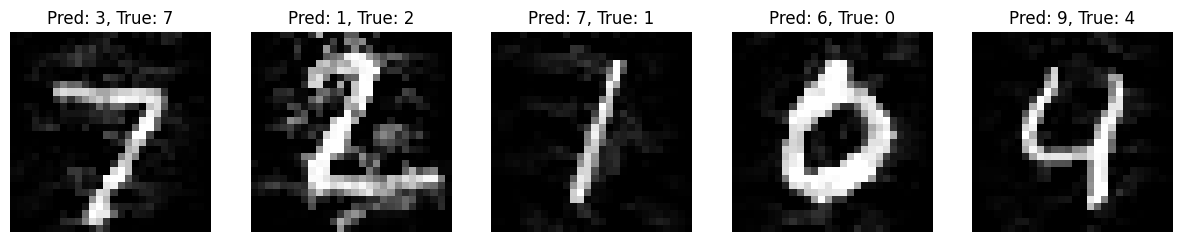

In [88]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load the perturbed dataset
perturbed_data = np.load('perturbed_mnist_LENET_CW_test.npz')
perturbed_images = perturbed_data['images']
perturbed_labels = perturbed_data['labels']

# Load the FCN model
fcn_model = tf.keras.models.load_model("../Models/Mnist/mnist_model_LENET.karas")

# Perform inference on the perturbed images
predictions = fcn_model.predict(perturbed_images)

# Get the predicted labels
predicted_labels = np.argmax(predictions, axis=1)

# Evaluate the accuracy
accuracy = np.mean(np.equal(predicted_labels, perturbed_labels))
print(f'Accuracy on perturbed dataset: {accuracy * 100:.2f}%')

# Calculate the confusion matrix
conf_matrix = confusion_matrix(perturbed_labels, predicted_labels)
class_names = [str(i) for i in range(10)]  # Assuming you have 10 classes (adjust if needed)

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Display some examples
num_examples = 5
plt.figure(figsize=(15, 4))
for i in range(num_examples):
    plt.subplot(1, num_examples, i + 1)
    plt.imshow(perturbed_images[i].reshape(28, 28), cmap='gray')
    plt.title(f'Pred: {predicted_labels[i]}, True: {perturbed_labels[i]}')
    plt.axis('off')

plt.show()


157/157 [==============================] - 1s 5ms/step
Accuracy on perturbed dataset: 95.14%


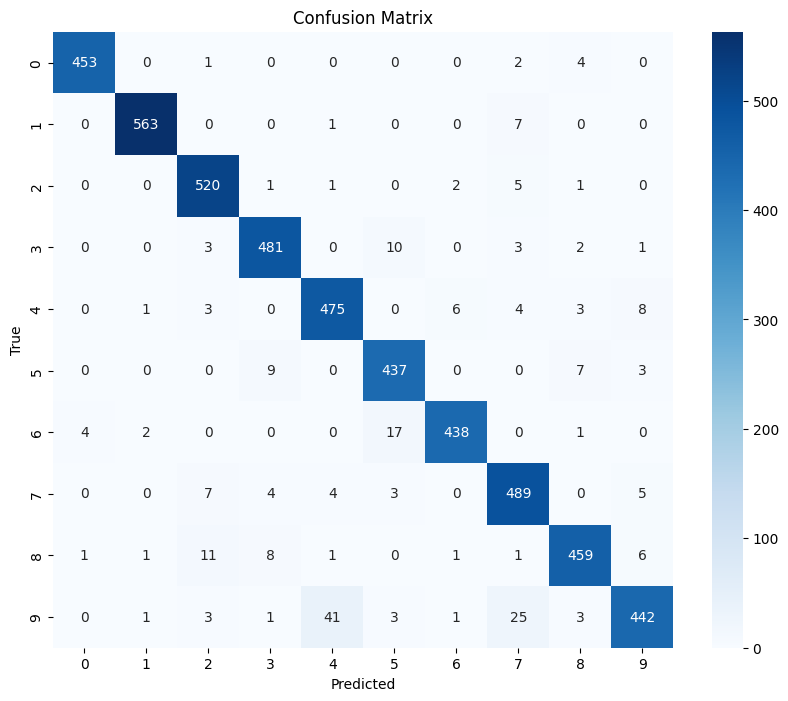

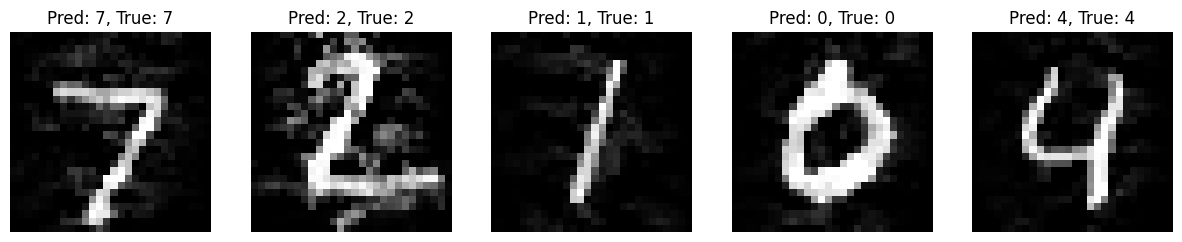

In [92]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load the perturbed dataset
perturbed_data = np.load('perturbed_mnist_LENET_CW_test.npz')
perturbed_images = perturbed_data['images']
perturbed_labels = perturbed_data['labels']

# Load the FCN model
fcn_model = tf.keras.models.load_model("../Models/Mnist/mnist_model_LENET_V2.karas")

# Perform inference on the perturbed images
predictions = fcn_model.predict(perturbed_images)

# Get the predicted labels
predicted_labels = np.argmax(predictions, axis=1)

# Evaluate the accuracy
accuracy = np.mean(np.equal(predicted_labels, perturbed_labels))
print(f'Accuracy on perturbed dataset: {accuracy * 100:.2f}%')

# Calculate the confusion matrix
conf_matrix = confusion_matrix(perturbed_labels, predicted_labels)
class_names = [str(i) for i in range(10)]  # Assuming you have 10 classes (adjust if needed)

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Display some examples
num_examples = 5
plt.figure(figsize=(15, 4))
for i in range(num_examples):
    plt.subplot(1, num_examples, i + 1)
    plt.imshow(perturbed_images[i].reshape(28, 28), cmap='gray')
    plt.title(f'Pred: {predicted_labels[i]}, True: {perturbed_labels[i]}')
    plt.axis('off')

plt.show()


157/157 [==============================] - 1s 3ms/step
Accuracy on perturbed dataset: 94.24%


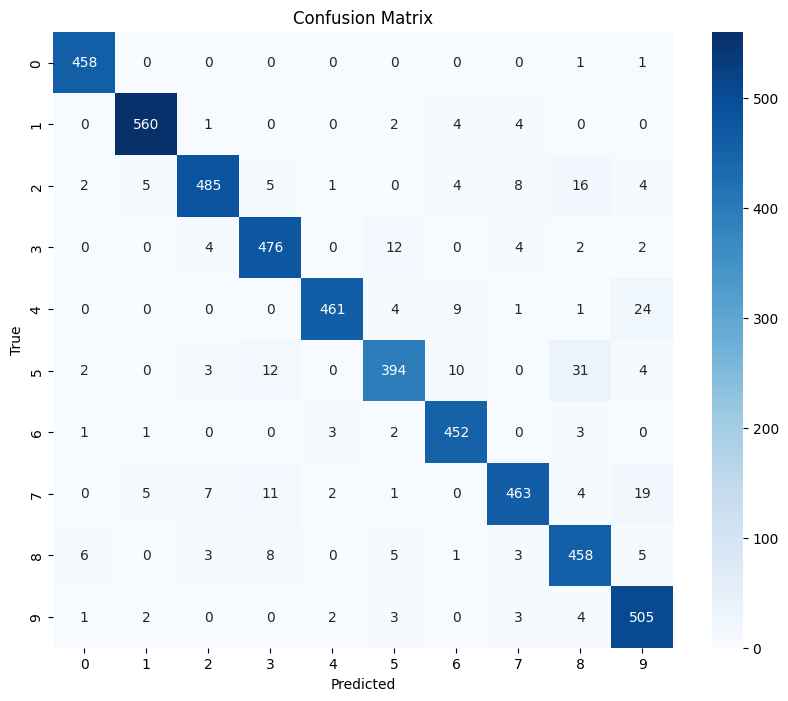

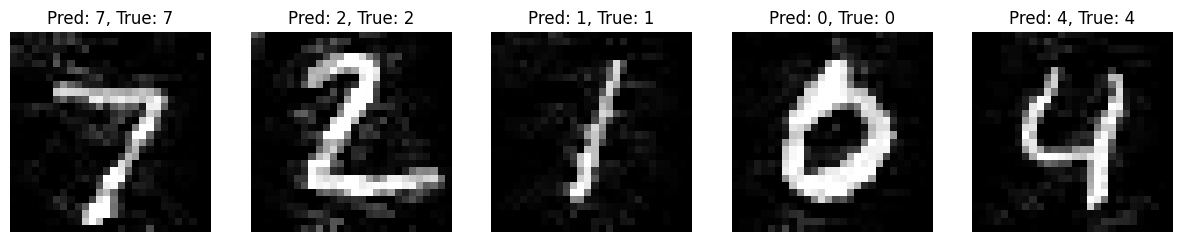

In [93]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load the perturbed dataset
perturbed_data = np.load('perturbed_mnist_2LFCN_CW_test.npz')
perturbed_images = perturbed_data['images']
perturbed_labels = perturbed_data['labels']

# Load the FCN model
fcn_model = tf.keras.models.load_model("../Models/Mnist/mnist_model_2LFCN_V2.karas")

# Perform inference on the perturbed images
predictions = fcn_model.predict(perturbed_images)

# Get the predicted labels
predicted_labels = np.argmax(predictions, axis=1)

# Evaluate the accuracy
accuracy = np.mean(np.equal(predicted_labels, perturbed_labels))
print(f'Accuracy on perturbed dataset: {accuracy * 100:.2f}%')

# Calculate the confusion matrix
conf_matrix = confusion_matrix(perturbed_labels, predicted_labels)
class_names = [str(i) for i in range(10)]  # Assuming you have 10 classes (adjust if needed)

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Display some examples
num_examples = 5
plt.figure(figsize=(15, 4))
for i in range(num_examples):
    plt.subplot(1, num_examples, i + 1)
    plt.imshow(perturbed_images[i].reshape(28, 28), cmap='gray')
    plt.title(f'Pred: {predicted_labels[i]}, True: {perturbed_labels[i]}')
    plt.axis('off')

plt.show()
